## Logistic regression

We want to minimize
$$\min_{x\in {\mathbb R}^{d}} f(x)=-\frac{1}{n}\sum_{i=1}^n \left(y_i \log (s(a_i^\top x)) + (1 - y_i) \log (1 - s(a_i^\top x))\right) + \frac{\ell_2}{2}\|x\|^2,$$
where  $a_i\in {\mathbb R}^{d}$, $y_i\in \{0, 1\}$, $s(z)=\frac{1}{1+\exp(-z)}$ is the sigmoid function.
The gradient is given by $\nabla f(x) = \frac{1}{n}\sum_{i=1}^n a_i(s(a_i^\top x)-y_i) + \ell_2 x$.

This is a smooth function with smoothness constant $L=\frac{1}{4}\lambda_{\max}(X^\top X) + \ell_2$, where $\lambda_{\max}$ denotes the largest eigenvalue.

For this experiment we used mushrooms and covtype datasets from the LibSVM library. Since the former is smaller and hence runs faster, we use it below.

Now add a l1-norm regularization term to f(x). Use proximal mapping to calculate the new update. 

In [16]:
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file

from optimizers_l1 import Gd_l1, Ad_grad_l1
from loss_functions import logistic_loss_l1, logistic_gradient

sns.set(style="whitegrid", context="talk", palette=sns.color_palette("bright"), color_codes=False)
data_path = './datasets/mushrooms'
markers = [',', 'o', '*', '^', 'D', 's']
labels = ['GD', 'AdGD', 'AdGD-L']

it_max = 5000

def logistic_smoothness(X):
    return 0.25 * np.max(la.eigvalsh(X.T @ X / X.shape[0]))


data = load_svmlight_file(data_path)
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Loss functions support only labels from {0, 1}
    y -= 1
n, d = X.shape
L = logistic_smoothness(X)
l2 = L / (10 * n)
w0 = np.zeros(d)
l1 = L / (5*n) # note that this number should not be bigger than 0.1 or so 

def loss_func(w):
    return logistic_loss_l1(w, X, y, l2, l1)

def grad_func(w):
    return logistic_gradient(w, X, y, l2)

In [17]:
gd = Gd_l1(lr=1 / L, l1=l1, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gd.run(w0=w0)

In [18]:
adgd = Ad_grad_l1(loss_func=loss_func, grad_func=grad_func, eps=0, l1=l1, it_max=it_max)
adgd.run(w0=w0)

In [19]:
adgdl = Ad_grad_l1(loss_func=loss_func, grad_func=grad_func, eps=1 / L ** 2, l1=l1, it_max=it_max)
adgdl.run(w0=w0)

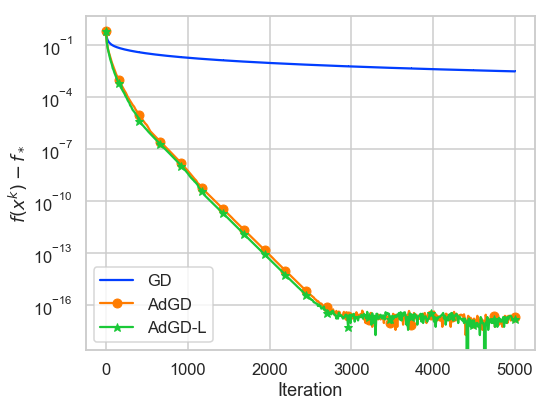

In [20]:
optimizers = [gd, adgd, adgdl]
for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(8, 6))
for opt, marker, label in zip(optimizers, markers, labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()